<a href="https://colab.research.google.com/github/Iamsbharti/ML101-Lab/blob/master/neural_network_scratch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

**Derivative**

In [36]:
# a hyperbola
def f(x):
  return 3 * x ** 2 -4*x +5

In [37]:
f(3.0)

20.0

In [38]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [39]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

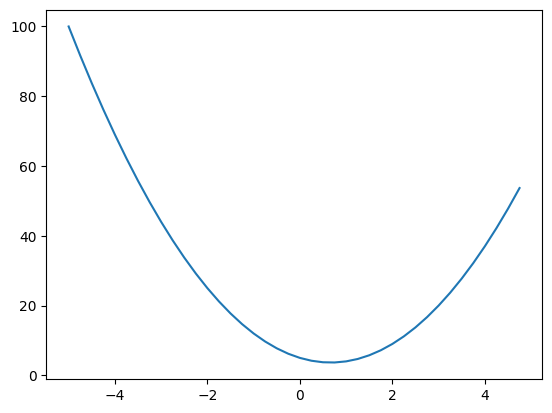

In [40]:
plt.plot(xs,ys)

-  a derivative is to find the amount of change recorded when input of the function is nudged in +ve /-ve direction ,the slope of the change.

In [41]:
h = 0.0000001 # amount of change
x = 2/3
# (f(x + h) - f(x)) /h

In [42]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b +c
print(d)

4.0


In [43]:
h = 0.0001 # amouint of change
# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
a +=h

d2 = a * b + c
print("d1:", d1)
print("d2:", d2)
print('slope:', (d1 - d2)/h)


d1: 4.0
d2: 3.999699999999999
slope: 3.000000000010772


- we are building a data-structure to store the value of a expression , from which values and operand they were created.
- _children is a set which stores the input used in generating the matematical expression
- _op stores the operand
- these are constructors to the `Value` class.

In [184]:
# neural networks needs mathematical operation so this is a datastructure to represent them.
# backpropagation
'''
we are going to derive derivate of each node with respect to the previous node
so derivative of L w.r.t L is 1
- L w.r.t d
- L w.r.t f
.... so on
- derivative of output w.r.t its leaf nodes.
`grad` varibale stores the derivative of node w.r.t to prev node. initialized to 0.0

- _backward => to store the values that propagates the gradient on any operation
'''

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._backward = lambda: None
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')
    # we will call this function which will provide the backward progated gradients on an node/operation

    def _backward():
      self.grad += 1.0  * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self * other

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) +1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  ## exp, __pow__, __truediv__ are for atomic calcualtion for tanh function (activation for neural net)
  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self,other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def backward(self):
    topo =[]
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [122]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'

d = e + c ; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [45]:
 print(d._prev,d._op)

{Value(data=10.0), Value(data=-6.0)} +


### because these mathematical expression can get larger , we are now going to build a way to visulaize these expression graphs

In [127]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'},) # left to right graph

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph ; create a rectangular ('record') node for it
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # if this values is a result of some operation , cretae an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # now connect this node to it
            dot.edge(uid + n._op , uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


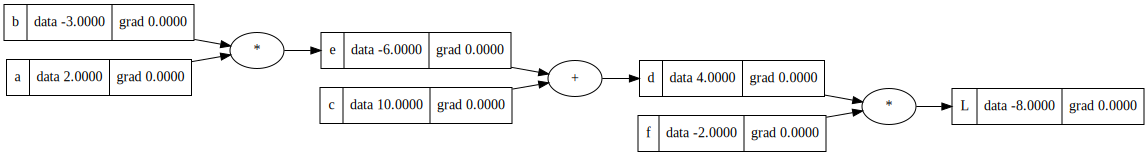

In [47]:
draw_dot(L)

### let's do the backpropagtion manually


In [48]:
def calculate_derivate():
  # changing L by h will give derivate to 1
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  # calculate L2 by nudings the a value by `h`
  L2 = L.data + h

  print((L2 - L1)/h)
calculate_derivate()

1.000000000000334


In [49]:
def calculate_derivate():
  h = 0.0001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # calculate L2 by nudings the a value by `h` to `a`
  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

6.000000000021544


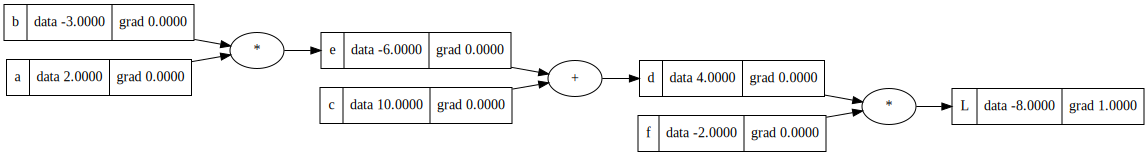

In [50]:
L.grad = 1
draw_dot(L)

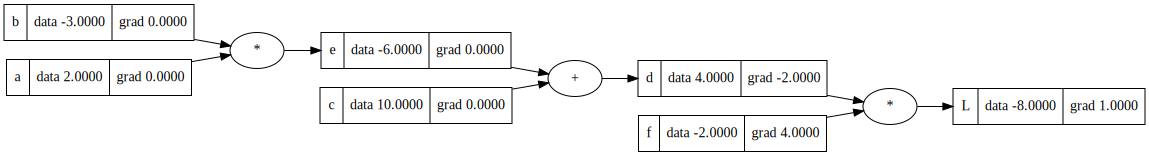

In [51]:
# now let's calculate grad for `d` first
'''
L = d * f
  dL/dd =??? => f

  - calculate
  . (f(x + h) - f(x)) / h
  . ((d + h) * f - d * f) / h)
  . (d * f + h * f - d * f) / h)
  . h * f / h
  . => f

  so from this calculation grad of `d` w.r.t `L` will be `d`
'''
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

In [52]:
# now using calculate_derivate method verify the grad
# dL/dd = -2
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `d` by `h`
  d.data += h

  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

-2.000000000000668


3.9999999999995595


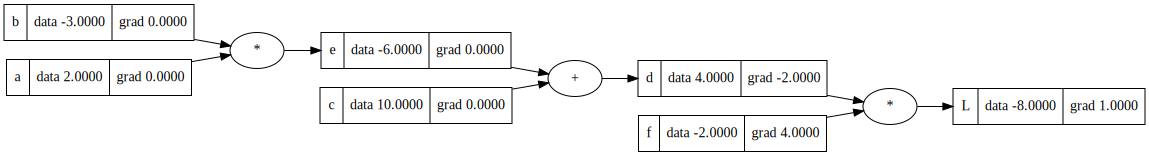

In [53]:
# dL/df = -4
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `f` by `h`
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

In [54]:
# now dL/dc
'''
- we know how L is sensitive to d & f
- no we want to know how L is sensitive to c

first we compute how c impacts d

- dd / dc = ? 1.0 # by calculas rule of sum function
- let's derive this
- d = c + e
. (f(x + h) - f(x)) / h
. (c + h + e) - (c + e) / h
. c + h + e - c - e / h
. h / h
. => 1.0

simialrly by symmetry
dd / de = 1.0
- derivative of sum operation is 1.0 (local derivative)

- how these info will help in computing how c impacts L (output)??
- by chain rule

The chain rule may also be expressed in Leibniz's notation. If a variable z depends on the variable y,
which itself depends on the variable x (that is, y and z are dependent variables),
then z depends on x as well, via the intermediate variable y.

- a dot prodct of the 2 derivatives

"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man,
then the car travels 2 × 4 = 8 times as fast as the man."

dL / dc =??

KNOW:
dL / dd = -2.0
dd / dc = 1.0

by chain rule
=> dL / dc = (dL / dd) * (dd / dc) => -2.0 * 1.0
=> since dd/dc is 1.0 so basically we copy over the derivateive dL/dd to dL/dc
- so what + node does is routes the local gradient

c.grad = -2.0 * 1 = -2.0
e.grad = -2.0 * 1 = -2.0
'''
c.grad = -2.0
e.grad = -2.0

In [55]:
# lets vierify this with calculate_derivative
# dL/dc = -2
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  # nudge `c` by `h`
  c = Value(10.0 + h, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

-1.9999999999988916


-2.000000000000668


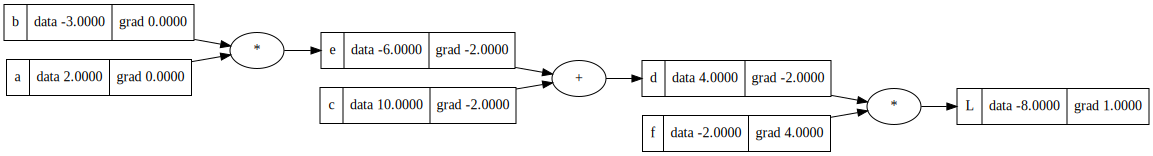

In [56]:
# dL/de = -2
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  # nudge `e` by `h`
  e.data += h

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

In [57]:
# so far derivatives are
'''
- dL / de = -2

now we have one node left; lets calcualte derivative of that
de / da = lcoal gradient ; how `e` changes w.r.t `a`
dL / da = (dL / de )* (de / da)

=> e = a * b
=> de / da ? = b # from oor first derivative derivation of `d`
--- + --
=> de / db ? = a

a.grad = (-2.0 * -3.0) = 6.0
b.grad = (-2.0 * 2.0) = -4.0
'''

a.grad = 6.0
b.grad = -4.0

In [58]:
# lets vierify this with calculate_derivative
# dL/da = 6.0
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  # nudge `a` by `h`
  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

6.000000000000227


3.9999999999995595


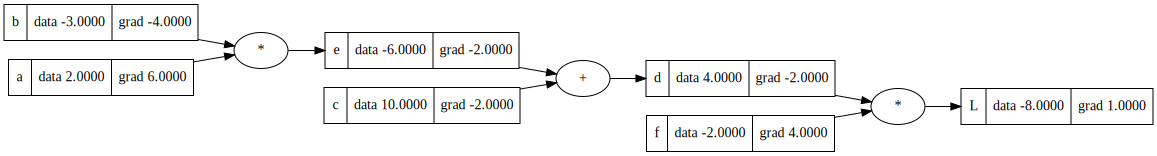

In [59]:
# dL/df = -4
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `f` by `h`
  f = Value(-2.0 + h, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

# back-propagtion is recursive application of chain - rule through out the graphs

In [60]:
# we try to move the L up by changing the leaf nodes by some value or step size
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# now apply forward pas
e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


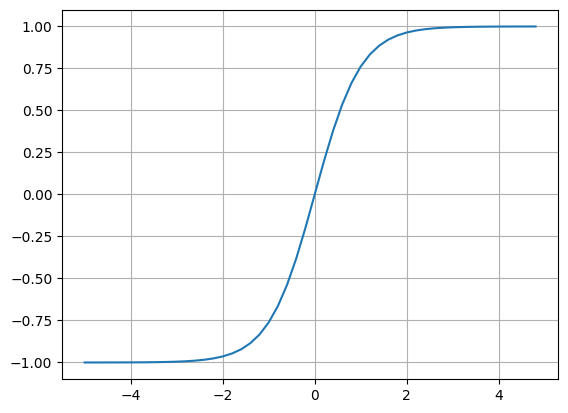

In [61]:
# now we will build a sample neural net , and a multilayer neuron called perceptron

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

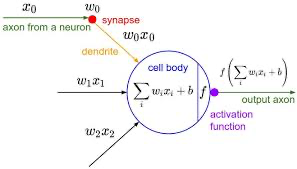

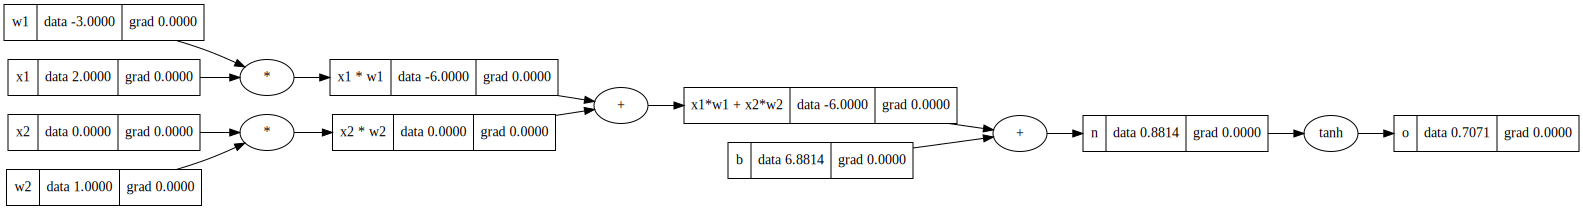

In [118]:
# inputs x1,x2 2 dim neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights; w1,w2 ;synaptics
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias
b = Value(6.8813735870195432,label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# output with a activation function (tanh)
o = n.tanh(); o.label='o'
draw_dot(o)

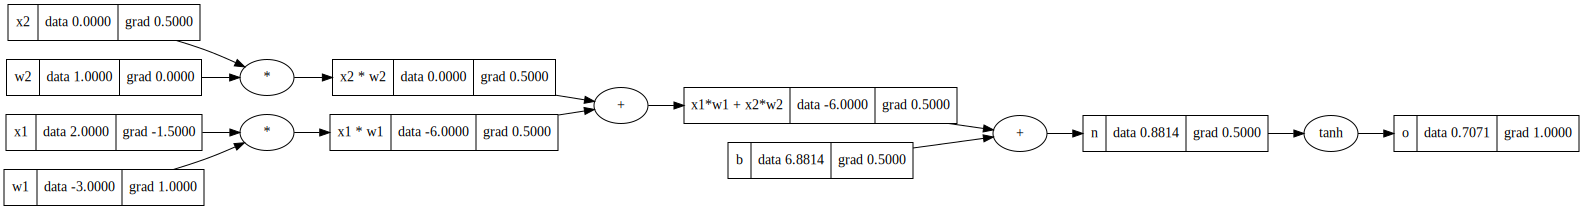

In [79]:
draw_dot(o)

In [66]:
# now we are going to compute the grad of each node manually
# grad of output `o` (base case)
# o.grad = 1.0
o.grad = 1.0

In [67]:
o.data

0.7071067811865476

In [70]:
# o = tanh(n)
# do/dn = 1 - o**2 (from derivative rule of tanh)
n.grad = 1 - o.data**2

In [72]:
# on + node
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [74]:
# again + node , the derivative is just forwaded
x1w1.grad = 0.5
x2w2.grad = 0.5

In [78]:
# actual weights and synapses
# multiplicateion node and a chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad  = x1.data * x1w1.grad

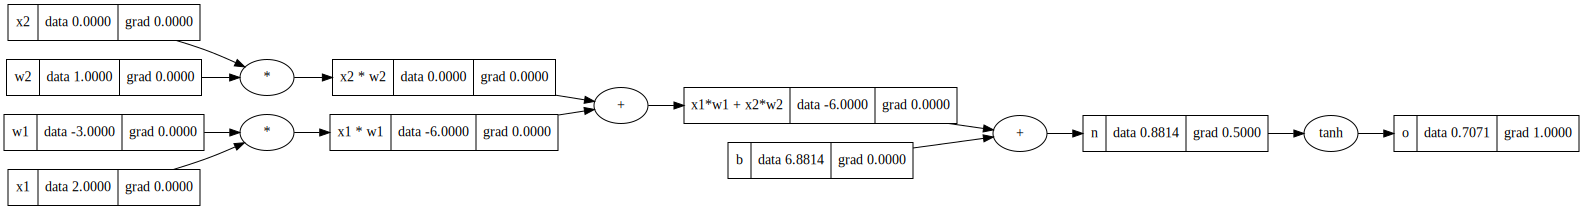

In [87]:
# now lets compute backpropagation by _backward function
# by calling _backward function , we will verify if the grad computed are similar to our manual appraoch
o.grad = 1.0
o._backward() # n node grad is populated
draw_dot(o)

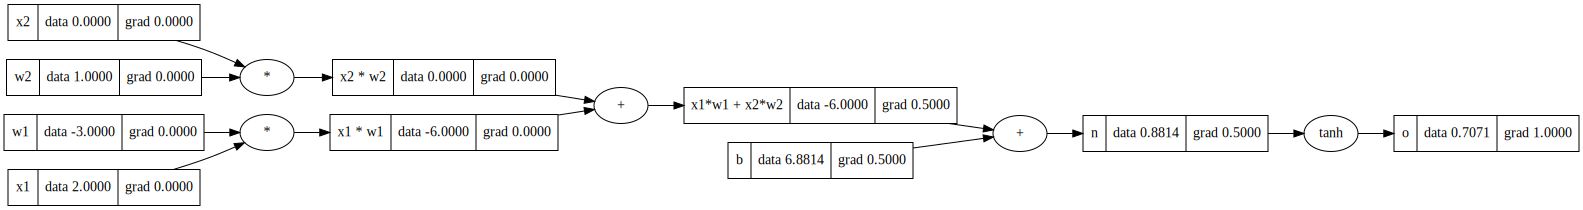

In [89]:
n._backward() # x1w1x2w2 and b grad is populated
draw_dot(o)

In [90]:
b._backward() # nothing happens as its leaf node

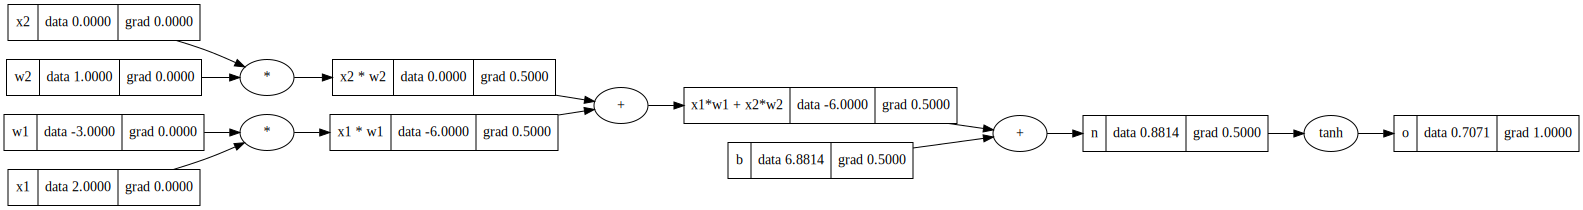

In [91]:
x1w1x2w2._backward()
draw_dot(o)

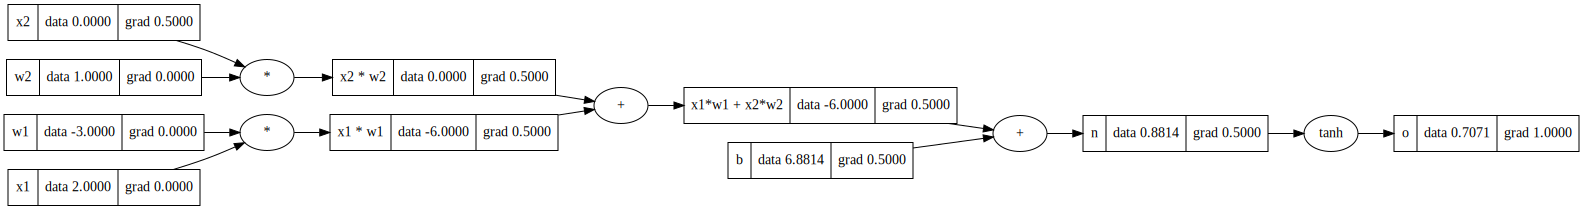

In [92]:
x2w2._backward()
draw_dot(o)

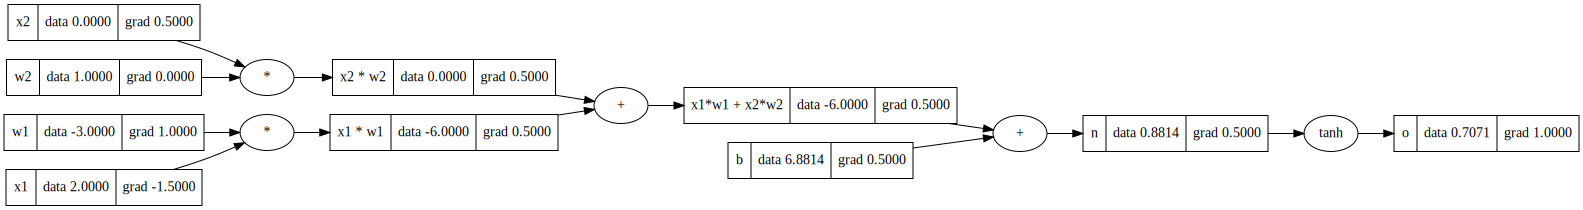

In [93]:
x1w1._backward()
draw_dot(o)

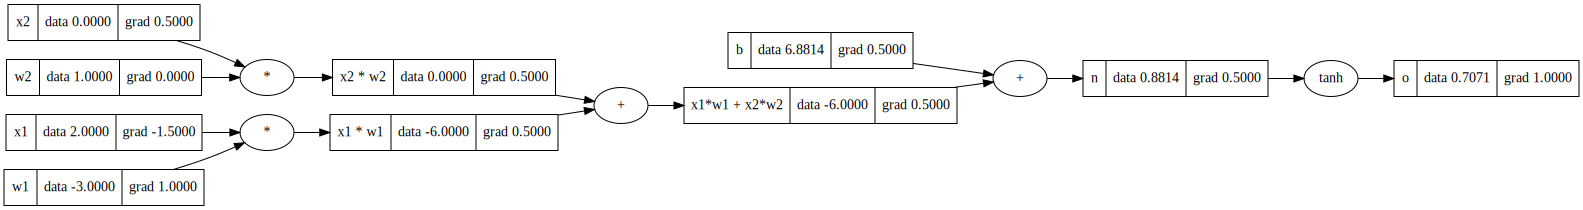

In [97]:
# here we manually run out back-propagation
# now we will use topological sort over the nodes of the graph and automate this process
o.grad=1.0
topo = []
visited =set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

# iterate in reverse and call _backward
for node in reversed(topo):
  node._backward()

draw_dot(o)
# here we populated all the grad values
# we will move this code to `value` class

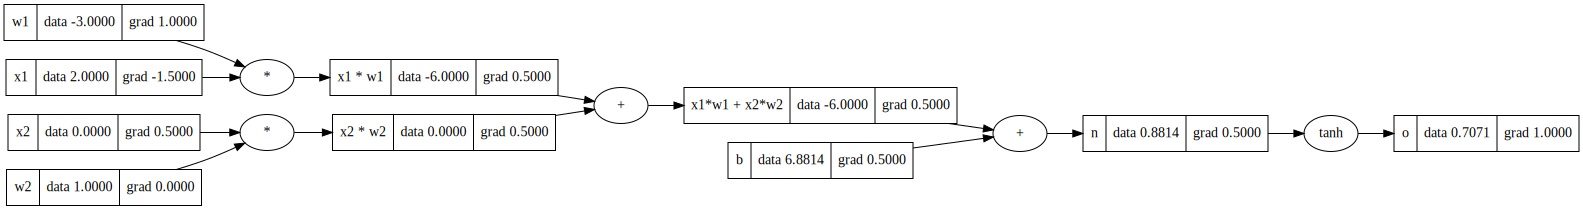

In [120]:
# back-propagation using backward()
o.backward()
draw_dot(o)

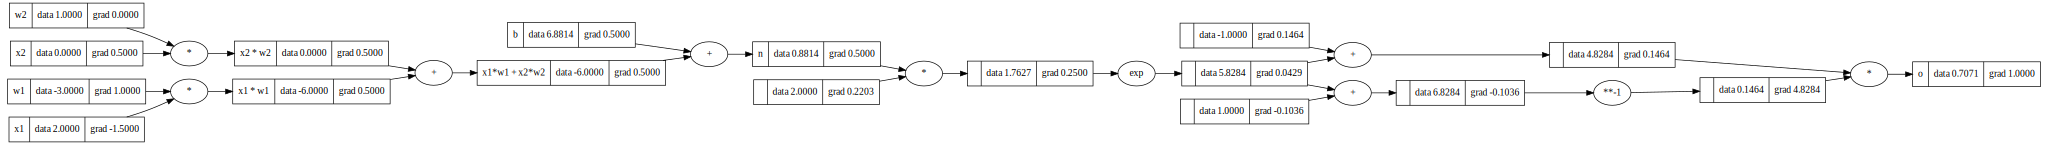

In [132]:
# now we will atomatically compute tanh
# inputs x1,x2 2 dim neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights; w1,w2 ;synaptics
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias
b = Value(6.8813735870195432,label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# ---
e = (2 * n).exp()
o = (e - 1)/(e + 1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [136]:
# validate our implementation with pytorch
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


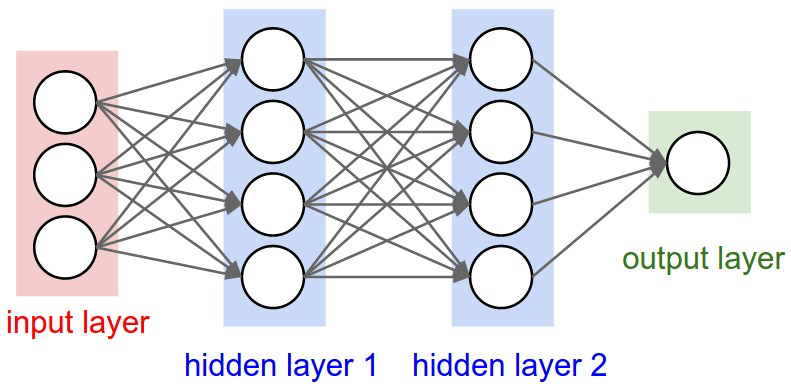

In [198]:
# Neural network
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # nin -> no of inputs , weights are randomly assigned from -1, 1 range
    self.b = Value(random.uniform(-1,1)) # same for the baises of neuron

  def __call__(self, x): # Neuron(x)
    # w * x + b
    activation = sum((wi*xi for wi, xi in zip(self.w, x)) , self.b)
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

# Layers of neurons
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

# Multi Layer perceptorns (MLP)
class MLP:
  def __init__(self, nin, nout):
    size = [nin] + nout
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nout))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def paramters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [250]:
# representation of above ML diagram
x =[2.0,3.0,-1.0] # 3 dimensional inputs
n = MLP(3, [4,4,1]) # 3 inputs ,  2 layers of 4 & 1 output
n(x)

Value(data=0.8012779044287762)

In [200]:
# sample input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=0.5159468427994237),
 Value(data=-0.17084796909356112),
 Value(data=0.7585426032891608),
 Value(data=0.1341485957227593)]

In [201]:
# so now our job is to tune this neural net to get the desired targets
# we will have to calculate a single no that somehow measeures the total performance of neural net;  called loss in deep learining.
# ygt - y's ground truth
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # indiviual loss

[Value(data=0.23430745899584582),
 Value(data=0.6874930903562722),
 Value(data=3.0924720875830185),
 Value(data=0.7496986542888697)]

In [202]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.763971291224006)

In [204]:
loss.backward()

In [205]:
n.layers[0].neurons[0].w[0].grad

-2.2157749615665447

In [210]:
n.layers[0].neurons[0].w[0].data

0.7103028437125554

In [209]:
print('No of parameters for this neural net:',len(n.paramters()))
n.paramters()

No of parameters for this neural net: 41


[Value(data=0.7103028437125554),
 Value(data=-0.5059279308453948),
 Value(data=0.680215905854098),
 Value(data=0.6828635496941566),
 Value(data=0.4913656280469294),
 Value(data=-0.14230300987817301),
 Value(data=-0.1842826029368243),
 Value(data=-0.823732744299025),
 Value(data=0.11773914553043707),
 Value(data=0.7416022763396912),
 Value(data=0.7008449237577237),
 Value(data=-0.9309803237761778),
 Value(data=0.7029925516918305),
 Value(data=-0.7465060478359868),
 Value(data=-0.29308206243962953),
 Value(data=-0.9003419912181392),
 Value(data=0.18417466259252158),
 Value(data=-0.6496162757492296),
 Value(data=0.6940785905776341),
 Value(data=-0.29974261501321076),
 Value(data=0.627673869128865),
 Value(data=0.9296672578463188),
 Value(data=-0.052785604712679124),
 Value(data=0.2808047101410307),
 Value(data=0.7844639137025053),
 Value(data=0.6068294205511524),
 Value(data=-0.6343698654531185),
 Value(data=0.5749681608854262),
 Value(data=0.8171395005236937),
 Value(data=-0.374898479729

In [211]:
# we will change w and b
# gradient decent (0.01) is the step size / learning rate

for p in n.paramters():
  p.data += -0.01 * p.grad

In [212]:
n.layers[0].neurons[0].w[0].data # this data has incresed and loss has reduced a bit

0.7324605933282208

In [244]:
# [1] forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.013729074609009042)

In [245]:
# [2] backward pass
loss.backward()

In [246]:
# [3] update params
for p in n.paramters():
  p.data += -0.1 * p.grad

In [279]:
# lets train neural net with step size and fixed no of steps
for k in range(20):
  # [1] forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean square error

  # [2] backward pass
  for p in n.paramters():
    p.grad = 0.0
  loss.backward()


  # [3] update params ; schoastic decent update
  for p in n.paramters():
    p.data += -0.05 * p.grad #(we need to move opposite toi the loss vector to minimize our loss hence -ve step size)

  print(k, loss.data)

print('------------------------')
ypred

0 0.0010078321359272885
1 0.0010059708538905211
2 0.0010041163209860366
3 0.0010022685007993269
4 0.0010004273571765125
5 0.0009985928542219683
6 0.0009967649562960983
7 0.0009949436280130438
8 0.00099312883423836
9 0.0009913205400869166
10 0.000989518710920582
11 0.000987723312346115
12 0.0009859343102129688
13 0.0009841516706112
14 0.000982375359869327
15 0.0009806053445522262
16 0.0009788415914591272
17 0.0009770840676214935
18 0.0009753327403010797
19 0.0009735875769878302
------------------------


[Value(data=0.985675036853988),
 Value(data=-0.9851481611049369),
 Value(data=-0.9817950391275537),
 Value(data=0.9852899595880562)]

In [ ]:
'''
- what are neural networks?
- neural networks are these mathematical expressions
- that take input as data
- and weights and parameters;

- mathematical expression to do forward pass
- followed by loss function ; loss function tries to measure tha acuracy of the predictions;
- usually the loss will be low when our predictions are mathcing our targets

- we manipulate the loss function such that when loss is low nn does what was intended.

- then we use back-propagation to know the gradients, which lets us tune the parametrs to minimize the loss.,

- we need to follow this process multiple times called as gradient decent
'''